# Preprocessing

## Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
import datetime
import math
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import skew, norm

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
df = {}
for df_name in ['train', 'test','all','monthly']:
    with open(data_path_out+df_name+'_dv.obj', 'rb') as file:
        df[df_name] = pickle.load(file)
        
all_data = df['all']
train = df['train']
test = df['test']
monthly_sales = df['monthly']

## Drop columns

### Max_Gust_SpeedKm_h

In [3]:
all_data = all_data.drop('Max_Gust_SpeedKm_h', axis = 1)
df['train'] = df['train'].drop('Max_Gust_SpeedKm_h', axis = 1)
df['test'] = df['test'].drop('Max_Gust_SpeedKm_h', axis = 1)

## Fill missing values

### Events

In [4]:
all_data.Events = all_data.Events.fillna('Normal')
print ("There are {} missing values of Events left".format(all_data['Events'].isna().sum(),
                                                                  all_data['Events'].isna().sum()/
                                                                  all_data.shape[0]*100))

There are 0 missing values of Events left


### Visibility

Since the Visibility has a high negative correlation  with Humidity, a good imputation method could be to group data by Humidity and use the median value to fill in missing values.

Intuitively the minimum visibility corresponds to the maximum humidity and viceversa.

Some humidity levels could not have visiblity values, so a good solution could be to take the mean between the two adiacent values

In [5]:
min_vis_dict=all_data.groupby('Max_Humidity')['Min_VisibilitykM'].apply(lambda x: x.median()).to_dict()
max_vis_dict=all_data.groupby('Min_Humidity')['Max_VisibilityKm'].apply(lambda x: x.median()).to_dict()
mean_vis_dict=all_data.groupby('Mean_Humidity')['Mean_VisibilityKm'].apply(lambda x: x.median()).to_dict()

#Function that replaces missing values of the median with the mean of next and previous values
def replace_nan_median(visdict_list):
    for visdict in visdict_list:
        item_list=[visdict[x] for x in visdict.keys()]
        for val in range(len(item_list)):
            if(math.isnan(item_list[val])):
                prev_val = (val-1) < 0 and item_list[val+1]  or item_list[val-1]
                next_val = (val+1) > len(item_list) and item_list[val-1] or item_list[val+1]
                item_list[val] = float(int((prev_val + next_val)/2))
        iterator = 0
        for k,i in visdict.items():
            visdict[k]=item_list[iterator]
            iterator+=1

#Function that replaces nan in the dataframe with the dictionary
#value corresponding to the samples humidity level

def replace_nan_df(col_name1,col_name2,dictionary):
    nan_index=all_data[all_data[col_name1].isnull()].index.tolist()
    for index in tqdm(nan_index):
        humidty_lvl = all_data.loc[index,col_name2] 
        all_data.loc[index,col_name1] = dictionary[humidty_lvl]

    
        
replace_nan_median([min_vis_dict,max_vis_dict,mean_vis_dict])

#Replacing nan in dataframe 
replace_nan_df('Min_VisibilitykM','Max_Humidity',min_vis_dict)
replace_nan_df('Max_VisibilityKm','Min_Humidity',max_vis_dict)
replace_nan_df('Mean_VisibilityKm','Mean_Humidity',mean_vis_dict)

for col in ["Min_VisibilitykM","Max_VisibilityKm","Mean_VisibilityKm"]:
    print ("There are {} missing values of {} left".
           format(all_data[col].isna().sum(),col))
os.system('say "Visibility Done."')

100%|██████████| 13959/13959 [00:16<00:00, 862.57it/s]

There are 0 missing values of Min_VisibilitykM left
There are 0 missing values of Max_VisibilityKm left
There are 0 missing values of Mean_VisibilityKm left


32512

# Cloud Cover

In [6]:
rf =  RandomForestClassifier(n_estimators=50,verbose=True)
cv_mode=True
cloud_data = all_data.copy()
cloud_data = pd.get_dummies(cloud_data)
cloud_data['Date_delta'] = (cloud_data['Date'] - cloud_data['Date'].min())  / np.timedelta64(1,'D')
cloud_data=cloud_data.drop('Date',axis=1)
nan_indexes=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
good_indexes =cloud_data[~cloud_data['CloudCover'].isnull()].index.tolist()

train_cloud = cloud_data.loc[good_indexes]
test_cloud = cloud_data.loc[nan_indexes]
print(train_cloud.shape)
print(test_cloud.shape)

X_train_cloud = train_cloud.copy()
X_train_cloud = X_train_cloud.drop(['CloudCover'], axis=1)
y_train_cloud = train_cloud['CloudCover']
test_cloud = test_cloud.drop('CloudCover',axis=1)

scaler = RobustScaler()
X_train_cloud = scaler.fit_transform(X_train_cloud)
test_cloud = scaler.transform(test_cloud)

if(cv_mode):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train_cloud)
    score_CV= cross_val_score(rf, X_train_cloud, y_train_cloud, cv = kf)

    print("The 10-fold crossvalidation of RF is {:.5f} +/- {:.3f}".format(score_CV.mean(),score_CV.std()))
    os.system('say "Crossvalidation done."')

(519111, 69)
(49599, 69)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.4s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.4s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   40.9s finished


The 10-fold crossvalidation of RF is 0.95677 +/- 0.086


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


In [7]:
rf.fit(X_train_cloud,y_train_cloud)
pred_results =rf.predict(test_cloud)
nan_index=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
result_df = pd.DataFrame(data={'Index' : nan_index,
                               'CloudCover': pred_results}).set_index('Index')
#replace missing values
for i in tqdm(nan_index):
    all_data.loc[i,'CloudCover'] = result_df.loc[i,'CloudCover']

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   50.7s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
100%|██████████| 49599/49599 [00:57<00:00, 861.41it/s]


## Region 2 missing values

## New Features

### Store is open and is holiday
This feature has been added for those stores that are open during holidays: we want to inspect if the sales are higher in those days

In [8]:
is_open_holiday =   all_data.IsHoliday & all_data.IsOpen
all_data['Hol_and_open'] = is_open_holiday

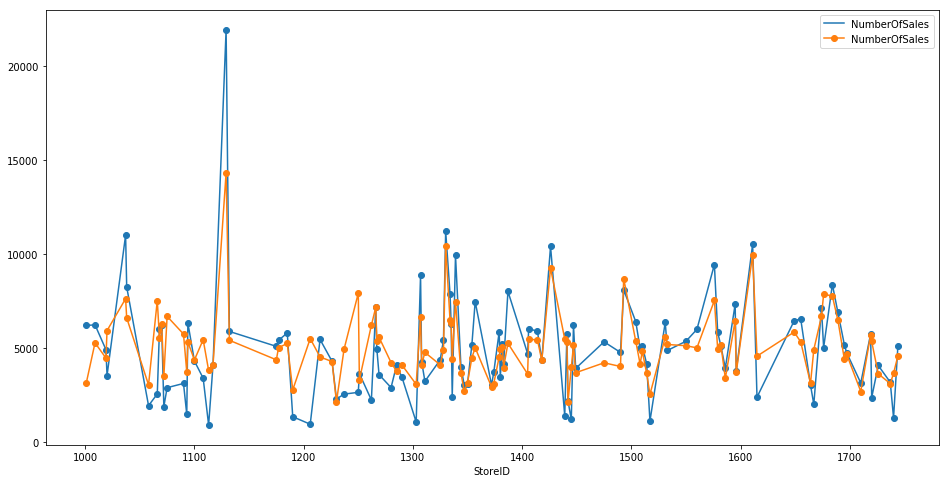

In [9]:
# For plotting reasons

holidays_open_mask = train.IsHoliday & train.IsOpen
open_mask = train['IsOpen'] == True
not_holidays_mask =  train['IsHoliday'] == False
not_holidays_open_mask = not_holidays_mask & open_mask

df_holidays_open = train[holidays_open_mask].groupby("StoreID")
avg_sales_holidays = df_holidays_open.NumberOfSales.mean()
avg_sales_holidays.plot(figsize=(16,8),legend=True,marker='o')


df_not_holidays_open = train[not_holidays_open_mask].groupby("StoreID")
avg_sales_not_holidays = df_not_holidays_open.NumberOfSales.mean()
avg_sales_not_holidays = avg_sales_not_holidays.filter(items = avg_sales_holidays.index)
avg_sales_not_holidays.plot(figsize=(16,8),legend=True,marker='o');

### Region's population density

In [10]:
all_data['Region_PD'] = all_data.Region_PopulationK.div(all_data.Region_AreaKM2,axis=0)

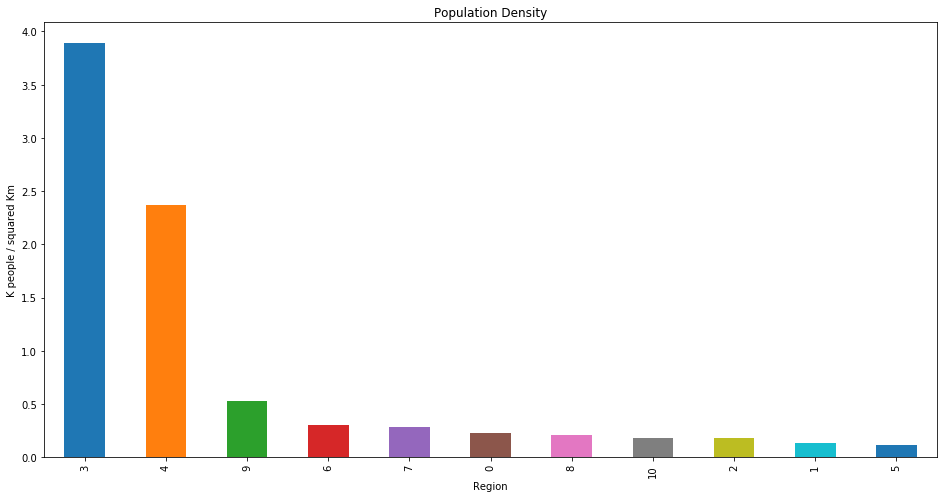

In [11]:
plot_PD = all_data.groupby("Region").Region_PD.mean().sort_values(ascending = False)\
        .plot(kind='bar', title='Population Density',figsize=(16,8));
plot_PD.set_ylabel("K people / squared Km");

## Seasonality features

In [12]:
all_data['year'] = all_data.Date.dt.year
all_data['month'] = all_data.Date.dt.month
all_data['day_of_month'] = all_data.Date.dt.day
all_data['day_of_week'] = all_data.Date.dt.dayofweek
all_data['day_of_year'] = all_data.Date.dt.dayofyear
all_data['WeekOfYear'] = all_data.Date.dt.weekofyear
all_data['days_in_month'] = all_data.Date.dt.daysinmonth

## One-Hot encoding

In [13]:
all_data = pd.get_dummies(all_data,columns=['Region','AssortmentType', 'StoreType', 'Events'])

## New Features Holidays

In [14]:
def num_of_features(regional_week_year,week,year,column_of_interest):
    num_holidays=0

    if week ==1:
        week_before=[52,year-1]
        week_after=[2,year]
    if week == 52:
        week_after=[1,year+1]
        week_before=[51,year]
    if (week>1) & (week<52):
        week_before=[week-1,year]
        week_after=[week+1,year]
    
    before_df = regional_week_year[(regional_week_year['WeekOfYear']==week_before[0])&
                                  (regional_week_year['year']==week_before[1])]
    
    after_df = regional_week_year[(regional_week_year['WeekOfYear']==week_after[0])&
                                  (regional_week_year['year']==week_after[1])]
    this_df = regional_week_year[(regional_week_year['WeekOfYear']==week)&
                                 (regional_week_year['year']==year)]
    
    num_ago = before_df[before_df[column_of_interest]][column_of_interest].sum()
    num_next = after_df[after_df[column_of_interest]][column_of_interest].sum()
    num_this = this_df[this_df[column_of_interest]][column_of_interest].sum()
    
    return num_ago,num_next,num_this

def create_new_features(before,current,after,column_of_interest):
    all_data[before] = 0
    all_data[current]=0
    all_data[after] = 0

    region_list= ["Region_"+str(d) for d in range(0,11)]
    for region in tqdm(region_list):
        curr_region = all_data[all_data[region]==1]

        #get all valid dates of that region
        regional_week_year=curr_region[['WeekOfYear','year',column_of_interest]]

        #get all store ids of that region
        regional_stores=len(curr_region['StoreID'].unique())

        week_year_list =regional_week_year[['WeekOfYear','year']].drop_duplicates().values.tolist()

        for date in week_year_list:
            num_ago,num_next,num_this = num_of_features(regional_week_year,
                                                        date[0],
                                                        date[1],
                                                        column_of_interest)

            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),before]=int(num_ago/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),after]=int(num_next/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),current]=int(num_this/regional_stores)

In [15]:
create_new_features('HolidaysWeekBefore','HolidaysWeekCurrent','HolidaysWeekAfter','IsHoliday')
create_new_features('PromoWeekBefore','PromoWeekCurrent','PromoWeekAfter','HasPromotions')

100%|██████████| 11/11 [01:02<00:00,  5.71s/it]


## Restore Train and Test Set

In [16]:
train_final = all_data[:train.shape[0]].copy()
train_final['NumberOfSales'] = train.NumberOfSales
train_final['NumberOfCustomers'] = train.NumberOfSales

# extract the test examples (we don't have the class value for this)
test_final = all_data[train.shape[0]:]

In [17]:
march_2016  = datetime.date(2016,3,31)
monthly_sales['Differential'] = 0        
        
for storeID, store in tqdm(monthly_sales.groupby('StoreID')):
    monthly_sales.loc[store.index,'one_step'] = store['NumberOfSales'].shift(1).fillna(0)
    monthly_sales.loc[store.index,'two_steps'] = store['NumberOfSales'].shift(2).fillna(0)

100%|██████████| 749/749 [00:01<00:00, 411.84it/s]


In [18]:
train_final['Differential'] = 0

#correct one step in april
april_mask = monthly_sales.Date.dt.month == 4
year_mask = monthly_sales.Date.dt.year == 2016
monthly_sales.loc[year_mask & april_mask,'one_step'] = 0

#compute differential
monthly_sales['Differential'] = monthly_sales['one_step'] - monthly_sales['two_steps']
pippo = monthly_sales[['StoreID','Date','Differential']]

#longest for ever - more than 10 mins - there must be a better way..
for index,row in tqdm(pippo.iterrows()):
    differential = row.Differential
    month = row.Date.month
    year = row.Date.year
    store = row.StoreID
    month_mask = train_final.Date.dt.month == month
    year_mask = train_final.Date.dt.year == year
    store_mask = train_final.StoreID == store
    
    train_final.loc[store_mask & year_mask & month_mask,'Differential'] = differential


17351it [10:28, 27.61it/s]


In [20]:
# train_final.to_csv(data_path_out+'train_final.csv')
# test_final.to_csv(data_path_out+'test_final.csv')

# Serialize dataframes for later use in implementations
with open(data_path_out+'train_pp.obj', 'wb') as file:
        pickle.dump(train_final, file)
# with open(data_path_in+'test_pp.obj', 'wb') as file:
#         pickle.dump(test_clean, file)